In [39]:
from virtual_swap.vswap_pass import VirtualSwap
from qiskit import QuantumCircuit

# from qiskit.test import QiskitTestCase
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import Unroller, TrivialLayout, ApplyLayout, SabreLayout
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure

from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition

# this code is buggy, see https://github.com/Qiskit/qiskit
# I can't use this version bc qiskit version missing DAGCircuit functionality

# build a toffoli
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)

# build a 2x2 square coupling map
coupling = CouplingMap.from_line(4)
coupling = CouplingMap.from_grid(2, 2)

In [40]:
from qiskit import transpile

qc2 = transpile(qc, coupling_map=coupling, basis_gates=["cx", "u3"])
pm = PassManager(RootiSwapWeylDecomposition())
qc3 = pm.run(qc2)
# qc3.draw(output='mpl')

print(f"Gate count: {qc3.count_ops()['riswap']}")
print(f"Depth: {qc3.depth()}")

Gate count: 18
Depth: 51


In [41]:
from virtual_swap.sqiswap_equiv import sel  # SessionEquivalenceLibrary

qc4 = transpile(
    qc, basis_gates=["u", "xx_plus_yy"], coupling_map=coupling, optimization_level=3
)
# bb.draw(output="mpl")

print(f"Gate count: {qc4.count_ops()['xx_plus_yy']}")
print(f"Depth: {qc4.depth()}")

Gate count: 15
Depth: 31


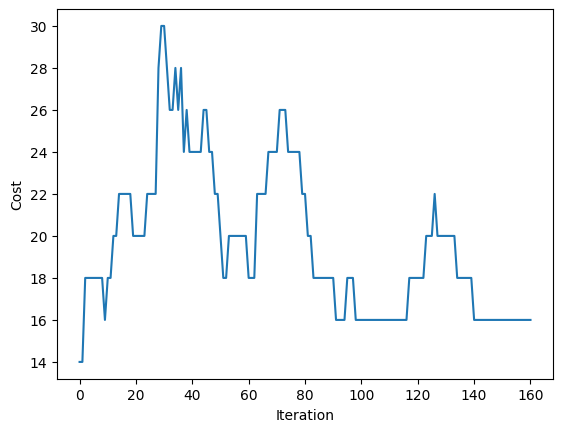

Gate count: 16
Depth: 39


In [42]:
# run the pass
pm = PassManager()
# need some basic unroll and layout
pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
pm.append(VirtualSwap(coupling, visualize=True))
pm.append(OptimizeSwapBeforeMeasure())

# XXX use the PR version once merged into Qiskit
pm.append(RootiSwapWeylDecomposition())
# set debug logging
import logging

logging.basicConfig(level=logging.INFO)
new_circ = pm.run(qc)
# new_circ.draw(output="mpl")
print(f"Gate count: {new_circ.count_ops()['riswap']}")
print(f"Depth: {new_circ.depth()}")

In [48]:
# run the pass
pm = PassManager()
# need some basic unroll and layout
routing_pass = VirtualSwap(coupling_map=coupling)
pm.append(
    [
        Unroller(["u", "cx"]),
        SabreLayout(coupling_map=coupling, routing_pass=routing_pass),
        ApplyLayout(),
    ]
)
pm.append(routing_pass)
pm.append(OptimizeSwapBeforeMeasure())

# XXX use the PR version once merged into Qiskit
pm.append(RootiSwapWeylDecomposition())
# set debug logging
import logging

logging.basicConfig(level=logging.INFO)
new_circ = pm.run(qc)
# new_circ.draw(output="mpl")
print(f"Gate count: {new_circ.count_ops()['riswap']}")
print(f"Depth: {new_circ.depth()}")

KeyError: "The item Qubit(QuantumRegister(4, 'q'), 2) does not exist in the Layout"